# This notebook reads text data from data extract created from FSHA Forms and runs predictive Models to predict the value 'Are there any inherent or cross contact allergens or intolerants?' , based on the Input Data

In [1]:
#import all necessary modules
from __future__ import print_function
import logging
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt
import os
import nltk
import string
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer
import re
import numpy as np
from numpy import array
from numpy import argmax
from scipy import signal
import random
import string
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import density
from sklearn.decomposition import PCA
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
import warnings
warnings.simplefilter('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## File name and other important parameters like ngram_range set

In [84]:
#These parameters will be input from command line
ngram_range_inp=(1,2)
filename = "D:/Pepsico/FSHA - RPA.xlsm"
#n_components = 0

# Define reusable modular method for Text Normalization (removal of stopwords, changing to lower case, removal of punctuation etc) - Q1

In [85]:
exclude = set(string.punctuation) 
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['from']
stop_words.extend(newStopWords)
table = str.maketrans('', '', string.punctuation)

porter = PorterStemmer()

def normalize_document(doc):
    # tokenize document
    tokens = doc.split()
    # remove punctuation from each word
    tokens = [w.translate(table) for w in tokens]
    # convert to lower case
    lower_tokens = [w.lower() for w in tokens]
    #remove spaces
    stripped = [w.strip() for w in lower_tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter stopwords out of document
    filtered_tokens = [token for token in words if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

#normalize_corpus = np.vectorize(normalize_document)

In [86]:
#import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata

#nlp = spacy.load('en', parse = False, tag=False, entity=False)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)

        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        # remove special characters    
        if special_char_removal:
            doc = remove_special_characters(doc)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

# Read the data extract file (tabular format with Input data(X) and target(Y))

In [87]:
fsha_data = pd.read_excel(filename)

In [88]:
fsha_data

,File Name,projName,accolNumber,PDA_projName,projType,projDesc,formulaNumber,owner,sector,center,...,Row6_Nuts,Row6_Peanuts,Row6_Soya,Row6_Celery,Row6_Lupin,Row6_Molluscs,Row6_Mustard,Row6_Sesame Seeds,Row6_Sulphites,Allergens_to_be_labeled (concatenated value from the rows)
0,#46565 FSHA 5.4.1Star Project G3 v2 + FS input...,S-T3-Star-• POL Star Puff (Chrupki) quality –POL,46565,1SKU Star Puffs Onion\n2 SKU Star Puffs Cheese...,Brand Refresh,Star Puffs Cheese & STar Hyper Cheese\nSeasoni...,NaN,Weronika Baranowska,ESSA,Warsaw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36559-FSHA-in process (Phase 1 Indian pellet l...,Simba Shapes Next Gen,36559,"Simba Shapes - Playz, Simba Shapes Twistz",Breakthrough - South Africa & Nigeria,Purchase an existing Pellet spec used by Pepsi...,unknown,Dina Atoyan (+7(495)9370550 (*63402) ),ESSA,Beaumont Park / Johannesburg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36559-FSHA-in process (Phase 2 Next Gen Launch...,Simba Shapes Next Gen,36559,Simba Shapes - Playz,Breakthrough - South Africa & Nigeria,"Commission a new pellet line in Prospecton, So...",unknown,Dina Atoyan (+7(495)9370550 (*63402) ),ESSA,Beaumont Park / Johannesburg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,36559-FSHA-in process (Phase 2 Next Gen Launch...,Simba Shapes Next Gen,36559,Simba Shapes Twistz,Breakthrough - South Africa & Nigeria,"Commission a new pellet line in Prospecton, So...",unknown,Dina Atoyan (+7(495)9370550 (*63402) ),ESSA,Beaumont Park / Johannesburg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Accolade Blend Flex project FSHA 5.4.1 + FS in...,Oil BlendFlex - HOSO,#44720,Lays and Simba Ruffles,Business continuation &/or Productivity,Validate a new oil blend for Lays and Simba to...,Lays and Simba Ruffles,Lizel Laubscher,ESSA,SSA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Baked Lays Fusion POL-FSHA-final G3 v2 09.03.1...,Lays-Baked Fusion-POL,35125,Baked Lay's Fusion,Refresh,Inclusions are added to the dough via side fee...,TBC,Bahar Aydın 0090 555 802 54 71,ESSA,Istanbul,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Baked Toppers FSHA 5.4.1 V2 FS input 18.10.17....,Walkers Lays Toppers,39559,Baked Toppers,Breakthrough,Topping of the current potato cracker design p...,not applicable,Holly Yoell (+44 116 2348841) / Dan Pyner (+44...,ESSA,Beaumont Park,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,BNL Maize grits FSHA Silesian - 5.4.1 v2 9.10...,Benelux Maize Grits RFP 2017,PM-1580,"Hamkaas, Fritelle & Cheetos",Productivity,Replacement of current supplier (Dacsa FR) wit...,na,Kal Mohmood / 07775030898,ESSA,BP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Cheetos Fashionista 45688 45689 45690 FSHA In ...,S-T3-Cheetos- Fashionista I&O- POL,456884568945690,Cheetos Mustache,Refresh,"One new extruded product, based on existing ex...",Not applicable,Weronika Baranowska,ESSA,Warsaw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Cheetos_Cerezza_Sweetcorn_Productivity_FSHA 8....,PRD - Reformulation Sweetcorn 10905989_IFF_SUA,46172,Cheetos Shots Sweetcorn / Cerezza TV Sweetcorn,Productivity,Reformulation of SweetCorn 10905989 seasoning ...,not provided,Zeynep Yolcu 0090 850 279 40 00,ESSA,Istanbul,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Based on Analysis select the Features (X)

In [89]:
#selecting set of columns as Features
data2=fsha_data[['preservatives', 'pH', 'waterActivity', 'packaging','otherFSA',
            'prodStorageDist', 'foodSafetyProdClaims','targetMarket','allergens','newIngredient']]


In [90]:
data2

,preservatives,pH,waterActivity,packaging,otherFSA,prodStorageDist,foodSafetyProdClaims,targetMarket,allergens,newIngredient
0,None,Not applicable,low moisture food,no modified atmosphere,Not applicable,"Store in a dry, cool and away from sun place.","claim 1 ""from corn""\nclaim 2 ""not fried""\nclai...","People with allergies to milk, lactose, peanuts.",Allergens in seasonings:\nCQ69 Vegetable Blend...,Yes
1,None,n/a,"Pellet (<0.6), Finished Product (<0.15)",Nitrogen flushed?,Moisture Content of Pellet : 10 - 12 %,Ambient,n/a,"Suitable for consumers, potential choking haza...",Inherent:\nCheddar Playz: Cereals containing G...,Yes
2,None,n/a,"Pellet (<0.6), Finished Product (<0.15)",Pellet WIP packaging not N2 flushed. 6 month s...,Moisture Content of Pellet : 10 - 12 %,Ambient,n/a,"Suitable for consumers, potential choking haza...",Pellets Inherent:\nCereals containing Gluten -...,Yes
3,None,n/a,"Pellet (<0.6), Finished Product (<0.15)",Pellet WIP packaging not N2 flushed. 6 month s...,Moisture Content of Pellet : 10 - 12 %,Ambient,n/a,"Suitable for consumers, potential choking haza...",Pellets Inherent:\nCereals containing Gluten -...,Yes
4,NaN,NaN,Low,Lays is nitrogen flushed,NaN,RTE,None,"Yes, no change to current product",Standard allergen management for Seasoning. Th...,No
5,E262 Sodium acetates (i) Sodium acetate (ii) S...,NaN,"low, approximately 0,04",nitrogen flushed bags,NaN,ambient,50% less fat comparing to fried potato chips,no,Inherent\n\nParmesan Cheese & Roasted Garlic B...,Yes
6,May be in topping/seasoning ingredients TBC fi...,NaN,Low water activity,Packaging conditions TBC,NaN,"Ambient, RTE",NaN,Allergen suffers. Made in a factory that handl...,"Inherent - Wheat, Gluten, Sulphites, Soya, Mil...",Yes
7,na,na,0.2,na,None,silo,na,Same as current,All current suppliers to PepsiCo have cross co...,No
8,None,Not applicable,low moisture food,no modified atmosphere,Not applicable,"Store in a dry, cool and away from sun place.",no claims,People with allergies to allergens present in ...,"One of below seasonings will be chosen, allerg...",No
9,E262 Sodium acetates (i) Sodium acetate (ii) S...,NaN,low,NaN,NaN,ambient,No preservatives,no,Base allergens: None\nTop seasoning: Milk\n\nC...,Yes


# Replace missing values with NA

In [91]:
data2.fillna('NA', inplace=True)

In [92]:
data2

,preservatives,pH,waterActivity,packaging,otherFSA,prodStorageDist,foodSafetyProdClaims,targetMarket,allergens,newIngredient
0,None,Not applicable,low moisture food,no modified atmosphere,Not applicable,"Store in a dry, cool and away from sun place.","claim 1 ""from corn""\nclaim 2 ""not fried""\nclai...","People with allergies to milk, lactose, peanuts.",Allergens in seasonings:\nCQ69 Vegetable Blend...,Yes
1,None,n/a,"Pellet (<0.6), Finished Product (<0.15)",Nitrogen flushed?,Moisture Content of Pellet : 10 - 12 %,Ambient,n/a,"Suitable for consumers, potential choking haza...",Inherent:\nCheddar Playz: Cereals containing G...,Yes
2,None,n/a,"Pellet (<0.6), Finished Product (<0.15)",Pellet WIP packaging not N2 flushed. 6 month s...,Moisture Content of Pellet : 10 - 12 %,Ambient,n/a,"Suitable for consumers, potential choking haza...",Pellets Inherent:\nCereals containing Gluten -...,Yes
3,None,n/a,"Pellet (<0.6), Finished Product (<0.15)",Pellet WIP packaging not N2 flushed. 6 month s...,Moisture Content of Pellet : 10 - 12 %,Ambient,n/a,"Suitable for consumers, potential choking haza...",Pellets Inherent:\nCereals containing Gluten -...,Yes
4,NA,NA,Low,Lays is nitrogen flushed,NA,RTE,None,"Yes, no change to current product",Standard allergen management for Seasoning. Th...,No
5,E262 Sodium acetates (i) Sodium acetate (ii) S...,NA,"low, approximately 0,04",nitrogen flushed bags,NA,ambient,50% less fat comparing to fried potato chips,no,Inherent\n\nParmesan Cheese & Roasted Garlic B...,Yes
6,May be in topping/seasoning ingredients TBC fi...,NA,Low water activity,Packaging conditions TBC,NA,"Ambient, RTE",NA,Allergen suffers. Made in a factory that handl...,"Inherent - Wheat, Gluten, Sulphites, Soya, Mil...",Yes
7,na,na,0.2,na,None,silo,na,Same as current,All current suppliers to PepsiCo have cross co...,No
8,None,Not applicable,low moisture food,no modified atmosphere,Not applicable,"Store in a dry, cool and away from sun place.",no claims,People with allergies to allergens present in ...,"One of below seasonings will be chosen, allerg...",No
9,E262 Sodium acetates (i) Sodium acetate (ii) S...,NA,low,NA,NA,ambient,No preservatives,no,Base allergens: None\nTop seasoning: Milk\n\nC...,Yes


In [93]:
train_df = data2

In [94]:
train_df

,preservatives,pH,waterActivity,packaging,otherFSA,prodStorageDist,foodSafetyProdClaims,targetMarket,allergens,newIngredient
0,None,Not applicable,low moisture food,no modified atmosphere,Not applicable,"Store in a dry, cool and away from sun place.","claim 1 ""from corn""\nclaim 2 ""not fried""\nclai...","People with allergies to milk, lactose, peanuts.",Allergens in seasonings:\nCQ69 Vegetable Blend...,Yes
1,None,n/a,"Pellet (<0.6), Finished Product (<0.15)",Nitrogen flushed?,Moisture Content of Pellet : 10 - 12 %,Ambient,n/a,"Suitable for consumers, potential choking haza...",Inherent:\nCheddar Playz: Cereals containing G...,Yes
2,None,n/a,"Pellet (<0.6), Finished Product (<0.15)",Pellet WIP packaging not N2 flushed. 6 month s...,Moisture Content of Pellet : 10 - 12 %,Ambient,n/a,"Suitable for consumers, potential choking haza...",Pellets Inherent:\nCereals containing Gluten -...,Yes
3,None,n/a,"Pellet (<0.6), Finished Product (<0.15)",Pellet WIP packaging not N2 flushed. 6 month s...,Moisture Content of Pellet : 10 - 12 %,Ambient,n/a,"Suitable for consumers, potential choking haza...",Pellets Inherent:\nCereals containing Gluten -...,Yes
4,NA,NA,Low,Lays is nitrogen flushed,NA,RTE,None,"Yes, no change to current product",Standard allergen management for Seasoning. Th...,No
5,E262 Sodium acetates (i) Sodium acetate (ii) S...,NA,"low, approximately 0,04",nitrogen flushed bags,NA,ambient,50% less fat comparing to fried potato chips,no,Inherent\n\nParmesan Cheese & Roasted Garlic B...,Yes
6,May be in topping/seasoning ingredients TBC fi...,NA,Low water activity,Packaging conditions TBC,NA,"Ambient, RTE",NA,Allergen suffers. Made in a factory that handl...,"Inherent - Wheat, Gluten, Sulphites, Soya, Mil...",Yes
7,na,na,0.2,na,None,silo,na,Same as current,All current suppliers to PepsiCo have cross co...,No
8,None,Not applicable,low moisture food,no modified atmosphere,Not applicable,"Store in a dry, cool and away from sun place.",no claims,People with allergies to allergens present in ...,"One of below seasonings will be chosen, allerg...",No
9,E262 Sodium acetates (i) Sodium acetate (ii) S...,NA,low,NA,NA,ambient,No preservatives,no,Base allergens: None\nTop seasoning: Milk\n\nC...,Yes


# Define reusable code to Vectorize Text column (ex: Allergens) using TF-IDF Vectorizer, after doing Text data normalization

In [96]:
# Vectorization of text data using TF-IDF Vectorizer

# Range (inclusive) of n-gram sizes for tokenizing text.
#NGRAM_RANGE 

# Limit on the number of features. We use the top 20K features.
#TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500


def ngram_vectorize(train_texts, train_labels,ngram_range):
    """Vectorizes texts as ngram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of uni-grams + bi-grams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': ngram_range,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Select top 'k' of the vectorized features.
    #selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    #selector.fit(x_train, train_labels)
    #x_train = selector.transform(x_train)

    x_train = x_train.astype('float32')
    return x_train

# Define method to concatenate normalized Text data

In [105]:
def norm_cols(train_df):

    train_df['norm_preservatives'] = normalize_corpus(train_df['preservatives'])
    train_df['norm_prodStorage'] = normalize_corpus(train_df['prodStorageDist'])
    #train_df['norm_waterActivity'] = normalize_corpus(train_df['waterActivity'])
    train_df['norm_packaging'] = normalize_corpus(train_df['packaging'])
    train_df['norm_otherFSA'] = normalize_corpus(train_df['otherFSA'])
    train_df['norm_pH'] = normalize_corpus(train_df['pH'])
    train_df['norm_foodSafety_prodClaims'] = normalize_corpus(train_df['foodSafetyProdClaims'])
    train_df['norm_targetMarket'] = normalize_corpus(train_df['targetMarket'])
    train_df['norm_newIngredient'] = normalize_corpus(train_df['newIngredient'])
    train_df['norm_allergens'] = normalize_corpus(train_df['allergens'])
    
    #train_df['all_cols'] = train_df['norm_preservatives']+" "+train_df['norm_prodStorage']+" "+train_df['norm_waterActivity']+" "+train_df['norm_packaging']+" "+train_df['norm_otherFSA']+" "+train_df['norm_prodStorageDist']+" "+train_df['norm_foodSafety_prodClaims']+" "+train_df['norm_targetMarket']+" "+train_df['norm_newIngredient']+" "+train_df['norm_allergens']
    #train_df['all_cols'] = train_df['norm_allergens']
    train_df = train_df.drop(['allergens',
 'newIngredient',
 'pH',
 'prodStorageDist',
 'waterActivity',
 'packaging',
 'preservatives',
 'otherFSA',
 'foodSafetyProdClaims',
 'targetMarket'],axis = 1)
    return train_df    

In [106]:
df = norm_cols(train_df)
df

,norm_preservatives,norm_prodStorage,norm_packaging,norm_otherFSA,norm_pH,norm_foodSafety_prodClaims,norm_targetMarket,norm_newIngredient,norm_allergens
0,none,store dry cool away sun place,no modified atmosphere,not applicable,not applicable,claim 1 corn claim 2 not fried claim 3 no pres...,people allergies milk lactose peanuts,yes,allergens seasonings cq69 vegetable blend mcco...
1,none,ambient,nitrogen flushed,moisture content pellet 10 12,na,na,suitable consumers potential choking hazard yo...,yes,inherent cheddar playz cereals containing glut...
2,none,ambient,pellet wip packaging not n2 flushed 6 month st...,moisture content pellet 10 12,na,na,suitable consumers potential choking hazard yo...,yes,pellets inherent cereals containing gluten whe...
3,none,ambient,pellet wip packaging not n2 flushed 6 month st...,moisture content pellet 10 12,na,na,suitable consumers potential choking hazard yo...,yes,pellets inherent cereals containing gluten whe...
4,na,rte,lays nitrogen flushed,na,na,none,yes no change current product,no,standard allergen management seasoning project...
5,e262 sodium acetates sodium acetate ii sodium ...,ambient,nitrogen flushed bags,na,na,50 less fat comparing fried potato chips,no,yes,inherent parmesan cheese roasted garlic baked ...
6,may toppingseasoning ingredients tbc final ing...,ambient rte,packaging conditions tbc,na,na,na,allergen suffers made factory handles many all...,yes,inherent wheat gluten sulphites soya milk lact...
7,na,silo,na,none,na,na,current,no,current suppliers pepsico cross contaminated m...
8,none,store dry cool away sun place,no modified atmosphere,not applicable,not applicable,no claims,people allergies allergens present product,no,one seasonings chosen allergens seasonings 109...
9,e262 sodium acetates sodium acetate ii sodium ...,ambient,na,na,na,no preservatives,no,yes,base allergens none top seasoning milk crossco...


In [117]:
import statistics 

def impute_target(fsha_data,targetName):
    train_y=[]
    for i in range (len(fsha_data)):
        if str(fsha_data[targetName][i]).strip().lower() =='yes':
            train_y.append(1)
        elif str(fsha_data[targetName][i]).strip().lower() =='no':
            train_y.append(0)
        else:
            train_y.append(-1)
               
    mode_y = statistics.mode(train_y)

    for i in range (len(fsha_data)):
        if train_y[i]==-1:
            train_y[i] = mode_y
            
    return train_y

In [118]:
train_y_microbial = impute_target(fsha_data,"potentialMicrobial")
#train_y_allergens = impute_target(fsha_data,"crossContactAllergens") - this is having all 1s
train_y_chokeHazard = impute_target(fsha_data,"chokeHazard")
train_y_opAllergens = impute_target(fsha_data,"operationalAllergen")

In [119]:
df['target']=train_y_microbial

In [130]:
df['target']=train_y_chokeHazard

In [ ]:
df['target']=train_y_opAllergens

# Change the sample size from here

In [120]:
n = 1000

In [131]:
#[random.choice(set(df['all_cols'])) for i in range(100)]

sampled_df = df[['norm_preservatives',
 'norm_prodStorage',
 'norm_packaging',
 'norm_otherFSA',
 'norm_pH',
 'norm_foodSafety_prodClaims',
 'norm_targetMarket',
 'norm_newIngredient',
 'norm_allergens',
 'target']].sample(n=n,replace=True).reset_index()

In [132]:
sampled_df['target'].value_counts()

0    786
1    214
Name: target, dtype: int64

In [133]:
sampled_df.to_csv('C:\\Users\\725191\\Desktop\\PepsiCo FSHA data\\Data extraction format\\Results_05July\\AllCols_1000_chokehazard.csv')

In [135]:
train_labels = train_y
n_gram_range = (1,1)    

#Vectorize the text data
x_ngram_allergens = ngram_vectorize(sampled_df['norm_allergens'], train_labels,n_gram_range).toarray()
x_ngram_preservatives = ngram_vectorize(sampled_df['norm_preservatives'], train_labels,n_gram_range).toarray()
x_ngram_pH = ngram_vectorize(train_df['norm_pH'], train_labels,n_gram_range).toarray()
#x_ngram_waterActivity = ngram_vectorize(sampled_df['norm_waterActivity'], train_labels,n_gram_range).toarray()
x_ngram_packaging = ngram_vectorize(sampled_df['norm_packaging'],train_labels,n_gram_range).toarray()
x_ngram_otherFSA = ngram_vectorize(sampled_df['norm_otherFSA'],train_labels,n_gram_range).toarray()
x_ngram_prodStorageDist = ngram_vectorize(sampled_df['norm_prodStorage'],train_labels,n_gram_range).toarray()
x_ngram_foodSafetyProdClaims = ngram_vectorize(sampled_df['norm_foodSafety_prodClaims'],train_labels,n_gram_range).toarray()
x_ngram_targetMarket = ngram_vectorize(sampled_df['norm_targetMarket'],train_labels,n_gram_range).toarray()
x_ngram_newIngredient = ngram_vectorize(sampled_df['norm_newIngredient'],train_labels,n_gram_range).toarray()

x_ngram = np.concatenate((x_ngram_allergens,x_ngram_preservatives,x_ngram_waterActivity,x_ngram_packaging,x_ngram_otherFSA,x_ngram_prodStorageDist,
                             x_ngram_foodSafetyProdClaims,x_ngram_targetMarket,x_ngram_newIngredient),axis =1) 

x_ngram_std = StandardScaler().fit_transform(x_ngram)   

In [136]:
x_ngram_std[10,:]

array([-0.27854177, -0.2928758 , -0.27223969, -0.2867948 , -0.64057475,
       -0.27854177,  3.391158  , -0.27854177, -0.5502745 , -0.42780924,
        3.391154  , -0.3891799 , -0.2928758 , -0.27223969,  1.5919011 ,
       -0.74709207, -0.2867948 , -0.27223969, -0.2614885 ,  2.8304167 ,
       -0.27854177, -0.2614885 , -0.4537279 , -0.52184623, -0.74709207,
       -0.27223969, -0.33518246, -0.2928758 , -0.6557744 ,  0.07436602,
       -0.27854177, -0.27223969, -0.33518246, -0.27223969, -0.41959652,
       -0.27223969, -0.27854177, -0.2867948 , -0.42008224, -0.42008224,
        3.391158  , -0.27223969,  3.391154  , -0.27854177, -0.27854177,
       -0.2984169 , -0.27223969, -0.27854177, -0.27854177, -0.2867948 ,
        0.27111807, -0.42008224,  1.0948138 , -0.27223969, -0.68437415,
       -0.27223903, -0.2867948 , -0.41959652, -0.52184623, -0.41959652,
       -0.13523851,  1.5919011 , -0.27223969, -0.3986075 , -0.7487757 ,
       -0.27223969, -0.2928758 , -0.2867948 , -0.27854177,  3.39

In [137]:
X,y = x_ngram_std,sampled_df['target']

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [139]:
print(X_train.shape)
print(X_test.shape)

(800, 233)
(200, 233)


In [140]:
#Apply PCA 
whiten = False
random_state = 42
svd_solver="full"
n_comp = 2

pca = PCA(n_components=n_comp,svd_solver=svd_solver,whiten=whiten, random_state=42)
pca.fit(X_train)
x_train_pca = pca.transform(X_train)

x_test_pca = pca.transform(X_test)
    
print(x_train_pca.shape)
print(x_test_pca.shape)

(800, 2)
(200, 2)


# Define method to evaluate Machine Learning models with the X and y vectors created above, and check the effectiveness of each. Also store the results in array to be plotted in graph for visualization

In [141]:
from datetime import datetime
import time
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(len(X_train))
    
    clf_descr = str(clf).split('(')[0]
    print("model name:"+clf_descr)
  
    a = datetime.now()
    
    if clf_descr.__contains__('tensorflow'):
        history = clf.fit(
            X_train,
            y_train,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(X_test, y_test),
            verbose=2, 
            batch_size=batch_size)
    else:
        clf.fit(X_train, y_train)
    
    b = datetime.now()
    c = a-b
    train_time = c.microseconds
    print("train time: %0.3fs" % train_time)

    pred = clf.predict(X_test)

    pred_train = clf.predict(X_train)
 
    if clf_descr.__contains__('tensorflow'):
        for i in range (len(pred)):
            if (pred[i]>=0.3):
                pred[i]=1
            else:
                pred[i]=0
        for i in range (len(pred_train)):        
            if (pred_train[i]>=0.3):
                pred_train[i]=1
            else:
                pred_train[i]=0
    
    f1_score = metrics.f1_score(y_test, pred)
    print("f1_score:   %0.3f" % f1_score )
    
    f1_score_train = metrics.f1_score(y_train, pred_train)
    print("f1_score_train:   %0.3f" % f1_score_train )
    
    print("classification report:")
    print(classification_report(y_test, pred))
    
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    
    return clf_descr,f1_score_train,f1_score,train_time

# Evaluate Machine Learning Models from a List (using the reusable method defined above). Store the results (Accuracy score - train, accuracy score - test, and training time) in a List for data visualization

In [142]:
# Not using MultinomialNaiveBayes, because sampled data has negative components. NaiveBayes expects frequencies in the positive
selector = SelectKBest(f_classif, k='all')
results_chokehazard_1000 = []
model_name = []

for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=5), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    selector_clf = benchmark(Pipeline([('selector', selector),('classifier', clf)]))
    print('=' * 80)
    print(name)
    results_chokehazard_1000.append(benchmark(clf))
    model_name.append(name)
    #model.append(clf)
    
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results_chokehazard_1000.append(benchmark(LinearSVC(loss='l2', penalty=penalty,dual=False, tol=1e-3)))
    model_name.append("LinearSVC"+" "+penalty)

    # Train SGD model
    results_chokehazard_1000.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,penalty=penalty)))
    model_name.append("SGDClassifier"+" "+penalty)


# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results_chokehazard_1000.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,penalty="elasticnet")))
model_name.append("SGD with Elastic Net penalty")


# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results_chokehazard_1000.append(benchmark(NearestCentroid()))
model_name.append("NearestCentroid (aka Rocchio classifier)")



________________________________________________________________________________
Training: 
800
model name:Pipeline
train time: 915000.000s
f1_score:   1.000
f1_score_train:   1.000
classification report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       152
          1       1.00      1.00      1.00        48

avg / total       1.00      1.00      1.00       200

confusion matrix:
[[152   0]
 [  0  48]]
Ridge Classifier
________________________________________________________________________________
Training: 
800
model name:RidgeClassifier
train time: 995000.000s
f1_score:   1.000
f1_score_train:   1.000
classification report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       152
          1       1.00      1.00      1.00        48

avg / total       1.00      1.00      1.00       200

confusion matrix:
[[152   0]
 [  0  48]]
dimensionality: 233
density: 1.000000
________________

# Define Neural Network model

In [143]:
def mlp_model(layers, units, dropout_rate, input_shape):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.

    # Returns
        An MLP model instance.
    """
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=1, activation='sigmoid'))
    return model

# Compile Model

In [144]:
learning_rate=1e-3
epochs=100
batch_size=128
layers=2
units=64
dropout_rate=0.2
model = mlp_model(layers=layers,units=units,dropout_rate=dropout_rate,input_shape=X.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_4 (Dropout)          (None, 233)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                14976     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 15,041
Trainable params: 15,041
Non-trainable params: 0
_________________________________________________________________


# Train model and store results in array

In [145]:
print('=' * 80)
print("Keras Dense Neural Network")
results_chokehazard_1000.append(benchmark(model))
model_name.append("Keras Dense Neural Network")

Keras Dense Neural Network
________________________________________________________________________________
Training: 
800
model name:<tensorflow.python.keras.engine.sequential.Sequential object at 0x000000001F206DD8>
Train on 800 samples, validate on 200 samples
Epoch 1/100
 - 0s - loss: 0.3386 - acc: 0.8562 - val_loss: 0.0756 - val_acc: 1.0000
Epoch 2/100
 - 0s - loss: 0.0700 - acc: 0.9962 - val_loss: 0.0171 - val_acc: 1.0000
Epoch 3/100
 - 0s - loss: 0.0217 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 1.0000
Epoch 4/100
 - 0s - loss: 0.0099 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 5/100
 - 0s - loss: 0.0069 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 6/100
 - 0s - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 7/100
 - 0s - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 8/100
 - 0s - loss: 0.0031 - acc: 1.0000 - val_loss: 9.9449e-04 - val_acc: 1.0000
Epoch 9/100
 - 0s - loss: 0.0024 - acc: 1.0000 - val_loss: 8

Epoch 87/100
 - 0s - loss: 1.1820e-04 - acc: 1.0000 - val_loss: 2.3000e-05 - val_acc: 1.0000
Epoch 88/100
 - 0s - loss: 1.0578e-04 - acc: 1.0000 - val_loss: 2.2476e-05 - val_acc: 1.0000
Epoch 89/100
 - 0s - loss: 1.1831e-04 - acc: 1.0000 - val_loss: 2.1921e-05 - val_acc: 1.0000
Epoch 90/100
 - 0s - loss: 1.0353e-04 - acc: 1.0000 - val_loss: 2.1378e-05 - val_acc: 1.0000
Epoch 91/100
 - 0s - loss: 9.7667e-05 - acc: 1.0000 - val_loss: 2.0866e-05 - val_acc: 1.0000
Epoch 92/100
 - 0s - loss: 1.0588e-04 - acc: 1.0000 - val_loss: 2.0390e-05 - val_acc: 1.0000
Epoch 93/100
 - 0s - loss: 1.2416e-04 - acc: 1.0000 - val_loss: 1.9913e-05 - val_acc: 1.0000
Epoch 94/100
 - 0s - loss: 1.0770e-04 - acc: 1.0000 - val_loss: 1.9480e-05 - val_acc: 1.0000
Epoch 95/100
 - 0s - loss: 1.2570e-04 - acc: 1.0000 - val_loss: 1.9043e-05 - val_acc: 1.0000
Epoch 96/100
 - 0s - loss: 9.7150e-05 - acc: 1.0000 - val_loss: 1.8623e-05 - val_acc: 1.0000
Epoch 97/100
 - 0s - loss: 1.4981e-04 - acc: 1.0000 - val_loss: 1.8185

In [159]:
import pickle
results_fileName='D:/Pepsico/results_chokehazard_1000.pkl'
with open(results_fileName, "wb") as f:
    w = pickle.dump(results_chokehazard_1000,f)

In [160]:
results_microbial=pd.read_pickle('D:/Pepsico/results_microbial_1000.pkl')
results_chokehazard=pd.read_pickle('D:/Pepsico/results_chokehazard_1000.pkl')

In [161]:
results_chokehazard

[('RidgeClassifier', 1.0, 1.0, 995000),
 ('Perceptron', 1.0, 1.0, 990000),
 ('PassiveAggressiveClassifier', 1.0, 1.0, 961000),
 ('KNeighborsClassifier', 1.0, 1.0, 0),
 ('RandomForestClassifier', 1.0, 1.0, 861000),
 ('LinearSVC', 1.0, 1.0, 950000),
 ('SGDClassifier', 1.0, 1.0, 981000),
 ('LinearSVC', 1.0, 1.0, 963000),
 ('SGDClassifier', 1.0, 1.0, 940000),
 ('SGDClassifier', 1.0, 1.0, 948000),
 ('NearestCentroid', 1.0, 1.0, 0),
 ('<tensorflow.python.keras.engine.sequential.Sequential object at 0x000000001F206DD8>',
  1.0,
  1.0,
  744000)]

In [162]:
results_microbial = [[x[i] for x in results_microbial] for i in range(4)]
clf_names, f1_score_train1, f1_score_test1, training_time1 = results_microbial

In [163]:
results_chokehazard = [[x[i] for x in results_chokehazard] for i in range(4)]
clf_names, f1_score_train2, f1_score_test2, training_time2 = results_chokehazard

In [165]:
f1_score_train1

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7000000000000001, 1.0]

In [187]:
f1_score_train2

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [186]:
df_f1scoretrain = pd.DataFrame({"One":f1_score_train1,"Two":f1_score_train2})
df_f1scoretrain['hmean']=df_f1scoretrain.apply(scipy.stats.hmean, axis=1) 
df_f1scoretrain

,One,Two,hmean
0,1.0,1.0,1.000000
1,1.0,1.0,1.000000
2,1.0,1.0,1.000000
3,1.0,1.0,1.000000
4,1.0,1.0,1.000000
5,1.0,1.0,1.000000
6,1.0,1.0,1.000000
7,1.0,1.0,1.000000
8,1.0,1.0,1.000000
9,1.0,1.0,1.000000


# Store the best model and accuracy for a sample Size in array

In [79]:
#Sample Size 100
index100=np.argmax(f1_score_test)
print(index100)
f1score100 = f1_score_test[index100]
print(f1score100)
print(model_name[index100])

0
0.4
Ridge Classifier


In [86]:
#Sample Size 500
index500=np.argmax(f1_score_test)
f1score500 = f1_score_test[index500]
print(f1score500)
print(model_name[index500])

1.0
Ridge Classifier


In [196]:
#Sample Size 1000
index1000=df_f1scoretrain.idxmax(axis = 0)[2]
f1score1000 = df_f1scoretrain['hmean'][index1000]
print(f1score1000)
print(model_name[index1000])

1.0
Ridge Classifier


In [195]:
df_f1scoretrain.idxmax(axis =0)[2]

0

In [101]:
#Sample Size 2000
index2000=np.argmax(f1_score_test)
f1score2000 = f1_score_test[index2000]
print(f1score2000)
print(model_name[index2000])

0.664440734557596
kNN


# Plot the accuracy scores (F1-scores) of the best model vs sample Size

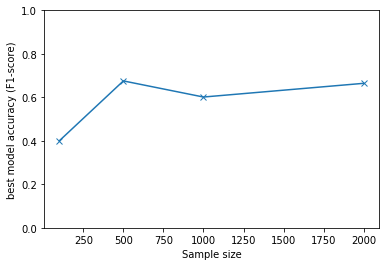

In [103]:
##Plotting the best model f1-scores

import matplotlib.pyplot as plt
plt.plot([100, 500, 1000, 2000],[f1score100,f1score500,f1score1000,f1score2000],marker="x")
plt.ylim(0,1)
plt.ylabel('best model accuracy (F1-score)')
plt.xlabel('Sample size')
plt.show()

# Print the best Model names at various sample Sizes

In [104]:
print("Best classifier is:"+model_name[index100],"||f1_score",f1score100)
print("Best classifier is:"+model_name[index500],"||f1_score",f1score500)
print("Best classifier is:"+model_name[index1000],"||f1_score",f1score1000)
print("Best classifier is:"+model_name[index2000],"||f1_score",f1score2000)

Best classifier is:Ridge Classifier ||f1_score 0.4
Best classifier is:Ridge Classifier ||f1_score 0.6754966887417219
Best classifier is:Ridge Classifier ||f1_score 0.6013986013986015
Best classifier is:kNN ||f1_score 0.664440734557596
